# Assignment 2 – Text Clustering
## Data Preparation, Preprocessing & Feature Engineering

**Categories:** Colon Cancer (a) · Liver Cancer (b) · Lung Cancer (c) · Stomach Cancer (d) · Thyroid Cancer (e)  
**Pipeline:** Raw Load → `text_raw` → Mild Clean (~150 words) → Deep Clean → Labels → Train/Test Split → BOW / TF-IDF / LDA / Word2Vec

In [56]:
# Imports
import os, re, html, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk

for res in ['stopwords', 'wordnet', 'averaged_perceptron_tagger_eng', 'punkt', 'punkt_tab']:
    try:
        nltk.download(res, quiet=True)
    except Exception:
        pass

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from gensim.models import Word2Vec

wnl = WordNetLemmatizer()

# Base NLTK English stopwords plus custom generic terms
STOP_WORDS = set(stopwords.words('english')) | {
    'abstracttext', 'label', 'jats', 'title', 'introduction', 'methods', 'results',
    'conclusions', 'background', 'objective', 'purpose', 'aim', 'aims',
    'copyright', 'doi', 'author', 'authors', 'journal', 'pubmed',
    'cancer', 'tumor', 'tumour', 'patient', 'patients', 'study', 'studies',
    'clinical', 'treatment', 'analysis', 'disease', 'case', 'cases',
}

# Mapping from NLTK POS tag prefix to WordNet POS
WORDNET_POS = {'N': 'n', 'V': 'v', 'J': 'a', 'R': 'r'}

# Color palette for 5 categories
COLORS = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B2']

print('Imports OK')

Imports OK


---
## Step 1 - Data Loading

In [57]:
# Path to raw CSV files from the data directory
DATA_DIR = './data'

# Map each source file to a single-letter label and a readable category name
FILE_LABEL = {
    'Colon_Cancer.csv':   ('a', 'Colon Cancer'),
    'Liver_Cancer.csv':   ('b', 'Liver Cancer'),
    'Lung_Cancer.csv':    ('c', 'Lung Cancer'),
    'Stomach_Cancer.csv': ('d', 'Stomach Cancer'),
    'Thyroid_Cancer.csv': ('e', 'Thyroid Cancer'),
}

dfs = []
for fname, (lbl, cat) in FILE_LABEL.items():
    df = pd.read_csv(os.path.join(DATA_DIR, fname), encoding='utf-8')
    df = df[['Text']].copy()
    df.rename(columns={'Text': 'text_raw'}, inplace=True)
    df['label']    = lbl
    df['category'] = cat
    dfs.append(df)
    print(f'{fname}: {len(df)} rows  ->  label={lbl}')

raw_df = pd.concat(dfs, ignore_index=True)
print(f'\nTotal: {len(raw_df)} rows')

Colon_Cancer.csv: 200 rows  ->  label=a
Liver_Cancer.csv: 200 rows  ->  label=b
Lung_Cancer.csv: 200 rows  ->  label=c
Stomach_Cancer.csv: 200 rows  ->  label=d
Thyroid_Cancer.csv: 200 rows  ->  label=e

Total: 1000 rows


In [58]:
# Preview one raw record
print(raw_df['text_raw'].iloc[0][:400], '...')

Surgery of colon cancer in a district hospital Colorectal cancer is a common illness and continues even today to be the second cause of death in the U.S.A., after lung cancer. Although the incidence of gastric and pancreatic cancer has declined dramatically in recent years, the incidence of colorectal cancer has increased. The aim of our study is to present our experience and results of surgical t ...


---
## Step 2 – Mild Cleaning (`text_raw_150`, ~150 words)

- Decode HTML entities (`&amp;` -> `&`)
- Strip XML/HTML tags, DOI strings, copyright lines
- Lowercase and collapse whitespace
- **Truncate to the first 150 words**

In [59]:
def mild_clean(text: str, max_words: int = 150) -> str:
    """Lightweight cleaning: decode HTML, remove metadata noise, lowercase, truncate."""
    if not text or not isinstance(text, str):
        return ''
    s = html.unescape(text)
    s = re.sub(r'(?i)(?:doi\s*:\s*)?10\.\d{4,}/\S+', ' ', s)  # DOI strings
    s = re.sub(r'<[^>]+>', ' ', s)                              # XML/HTML tags
    s = re.sub(r'\u00a9\s*\d{4}[^.]*\.', ' ', s)              # copyright symbol lines
    s = re.sub(r'copyright[^;.]*[;.]', ' ', s, flags=re.IGNORECASE)
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()                         # collapse all whitespace
    return ' '.join(s.split()[:max_words])


raw_df['text_raw_150'] = raw_df['text_raw'].apply(mild_clean)

wc = raw_df['text_raw_150'].str.split().str.len()
print('Word count in text_raw_150:')
print(f'  min={wc.min()},  max={wc.max()},  mean={wc.mean():.1f}')
print('\nSample (row 0):', raw_df['text_raw_150'].iloc[0][:300], '...')

Word count in text_raw_150:
  min=122,  max=150,  mean=150.0

Sample (row 0): surgery of colon cancer in a district hospital colorectal cancer is a common illness and continues even today to be the second cause of death in the u.s.a., after lung cancer. although the incidence of gastric and pancreatic cancer has declined dramatically in recent years, the incidence of colorect ...


---
## Step 3 – Deep Cleaning (`text_clean`)

Applied on top of `text_raw_150`:
- Remove digits and punctuation
- POS-aware lemmatization (WordNet)
- Remove stopwords (NLTK + custom generic terms)

> Disease-specific terms (e.g. "colon", "thyroid") are **intentionally kept** — unlike Assignment 1.

In [60]:
def _wn_pos(tag: str) -> str:
    """Map the first character of an NLTK POS tag to a WordNet POS constant."""
    return WORDNET_POS.get(tag[0] if tag else '', 'n')


def deep_clean(text: str) -> str:
    """Remove digits/punctuation, POS-lemmatize, and strip stopwords."""
    if not text or not isinstance(text, str):
        return ''
    s = re.sub(r'\d+', ' ', text.lower())
    s = re.sub(r'[^a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    words = s.split()
    if not words:
        return ''
    try:
        tagged = pos_tag(words)
        words  = [wnl.lemmatize(w, _wn_pos(tag)) for w, tag in tagged]
    except LookupError:
        pass  # fall back to un-lemmatized tokens
    return ' '.join(w for w in words if w and w not in STOP_WORDS)


raw_df['text_clean'] = raw_df['text_raw_150'].apply(deep_clean)

wc2 = raw_df['text_clean'].str.split().str.len()
print('Word count in text_clean:')
print(f'  min={wc2.min()},  max={wc2.max()},  mean={wc2.mean():.1f}')
print('\nSample (row 0):', raw_df['text_clean'].iloc[0][:300], '...')

Word count in text_clean:
  min=59,  max=120,  mean=88.3

Sample (row 0): surgery colon district hospital colorectal common illness continue even today second cause death u lung although incidence gastric pancreatic decline dramatically recent year incidence colorectal increase present experience result surgical technique apply clinic colorectal complication present exper ...


---
## Step 4 – Assemble & Save `processed_data.csv`

In [61]:
processed = raw_df[['text_raw', 'text_raw_150', 'text_clean', 'label', 'category']].copy()

processed.to_csv('processed_data.csv', index=False, encoding='utf-8')
print(f'Saved -> processed_data.csv  ({len(processed)} rows)')
processed.head(3)

Saved -> processed_data.csv  (1000 rows)


,text_raw,text_raw_150,text_clean,label,category
0,Surgery of colon cancer in a district hospital...,surgery of colon cancer in a district hospital...,surgery colon district hospital colorectal com...,a,Colon Cancer
1,Macrophage Migration Inhibitory Factor (MIF) U...,macrophage migration inhibitory factor (mif) u...,macrophage migration inhibitory factor mif upr...,a,Colon Cancer
2,Left-Sided Colon Cancer and Right-Sided Colon ...,left-sided colon cancer and right-sided colon ...,left sided colon right side colon two differen...,a,Colon Cancer


### Dataset Summary Table

In [62]:
# Per-category summary: document count and average word counts at each cleaning stage
summary = (
    processed
    .assign(
        wc_raw_150 = processed['text_raw_150'].str.split().str.len(),
        wc_clean   = processed['text_clean'].str.split().str.len(),
    )
    .groupby(['label', 'category'])
    .agg(
        doc_count      = ('text_raw',   'count'),
        avg_words_mild = ('wc_raw_150', 'mean'),
        avg_words_deep = ('wc_clean',   'mean'),
    )
    .reset_index()
    .rename(columns={
        'label':           'Label',
        'category':        'Category',
        'doc_count':       'Docs',
        'avg_words_mild':  'Avg Words (text_raw_150)',
        'avg_words_deep':  'Avg Words (text_clean)',
    })
)
summary['Avg Words (text_raw_150)'] = summary['Avg Words (text_raw_150)'].round(1)
summary['Avg Words (text_clean)']   = summary['Avg Words (text_clean)'].round(1)

print('=== Dataset Summary ===')
try:
    display(summary)
except NameError:
    print(summary.to_string(index=False))

=== Dataset Summary ===


,Label,Category,Docs,Avg Words (text_raw_150),Avg Words (text_clean)
0,a,Colon Cancer,200,150.0,88.9
1,b,Liver Cancer,200,150.0,91.5
2,c,Lung Cancer,200,150.0,89.5
3,d,Stomach Cancer,200,150.0,85.2
4,e,Thyroid Cancer,200,149.9,86.6


---
## Step 5 – Train / Test Split (80 / 20, stratified)

> Clustering is unsupervised — labels are **not** used during training.  
> The test set is reserved so that true labels can be compared against cluster assignments for Kappa evaluation.

In [63]:
train_df, test_df = train_test_split(
    processed, test_size=0.2, random_state=42, stratify=processed['label']
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df.to_csv('train.csv', index=False, encoding='utf-8')
test_df.to_csv('test.csv',   index=False, encoding='utf-8')

print(f'Train: {len(train_df)} rows  |  Test: {len(test_df)} rows')
print('\nTrain label counts:', train_df['label'].value_counts().sort_index().to_dict())
print('Test  label counts:', test_df['label'].value_counts().sort_index().to_dict())

Train: 800 rows  |  Test: 200 rows

Train label counts: {'a': 160, 'b': 160, 'c': 160, 'd': 160, 'e': 160}
Test  label counts: {'a': 40, 'b': 40, 'c': 40, 'd': 40, 'e': 40}


---
## Step 6 – Feature Engineering

Four representations are built from `text_clean` on the full 1000-document corpus:

| # | Method | Tool |
|---|--------|---------|
| 1 | BOW | `CountVectorizer` |
| 2 | TF-IDF | `TfidfVectorizer` |
| 3 | LDA | `LatentDirichletAllocation` |
| 4 | Word2Vec | `gensim.Word2Vec` (mean pooling) |

In [64]:
# --- BOW ---
bow_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.95)
X_bow = bow_vectorizer.fit_transform(processed['text_clean'])
print('BOW matrix:', X_bow.shape)

BOW matrix: (1000, 4076)


In [65]:
# --- TF-IDF ---
# sublinear_tf=True applies log(1 + tf) to dampen the effect of very frequent terms
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.95, sublinear_tf=True)
X_tfidf = tfidf_vectorizer.fit_transform(processed['text_clean'])
print('TF-IDF matrix:', X_tfidf.shape)

TF-IDF matrix: (1000, 4076)


#### Visualization – Top 10 TF-IDF Terms per Category

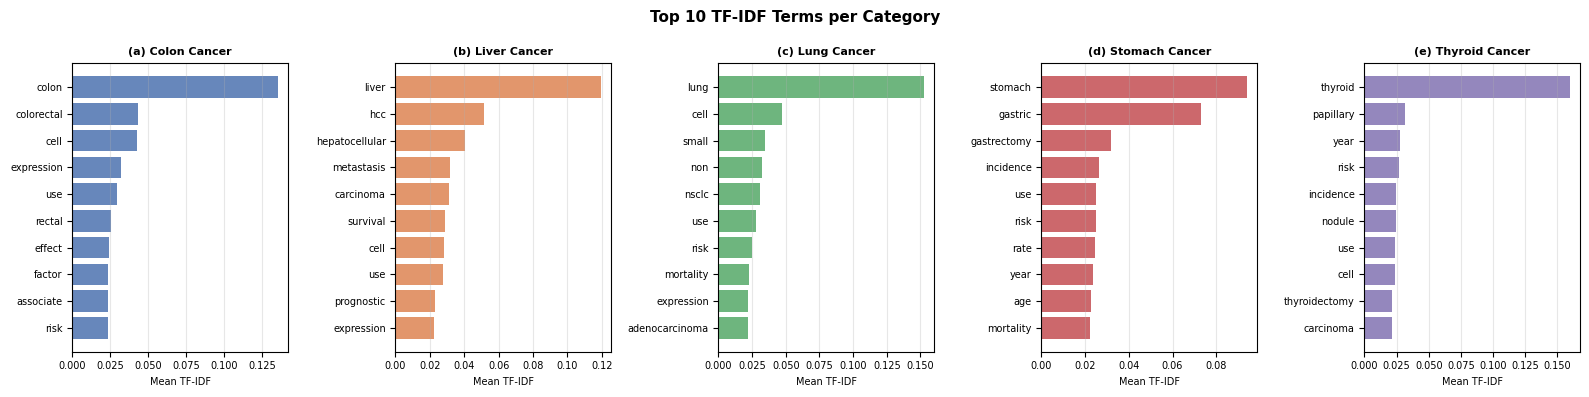

In [66]:
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

fig, axes = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for ax, (lbl, cat), color in zip(axes, FILE_LABEL.values(), COLORS):
    mask       = processed['label'] == lbl
    scores     = np.asarray(X_tfidf[mask.values].mean(axis=0)).flatten()
    top_idx    = scores.argsort()[::-1][:10]
    top_terms  = tfidf_vocab[top_idx][::-1]
    top_scores = scores[top_idx][::-1]
    ax.barh(top_terms, top_scores, color=color, alpha=0.85)
    ax.set_title(f'({lbl}) {cat}', fontsize=8, fontweight='bold')
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_xlabel('Mean TF-IDF', fontsize=7)
    ax.grid(axis='x', alpha=0.3)

fig.suptitle('Top 10 TF-IDF Terms per Category', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig('viz_tfidf_top_terms.png', dpi=150)
plt.show()

In [67]:
# --- LDA ---
# Uses the BOW matrix as input; n_components=5 matches the number of categories
lda_model = LatentDirichletAllocation(
    n_components=5, max_iter=20, random_state=42, learning_method='batch'
)
X_lda = lda_model.fit_transform(X_bow)   # shape: (n_docs, 5)
print('LDA matrix:', X_lda.shape)

LDA matrix: (1000, 5)


#### Visualization – LDA Topic–Word Heatmap

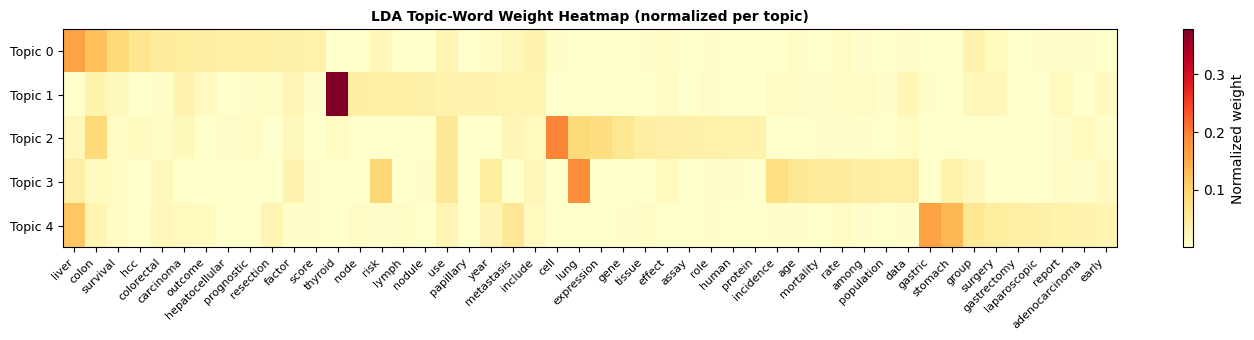

In [68]:
# Show the top 12 words for each of the 5 LDA topics as a heatmap
N_TOP     = 12
bow_vocab = bow_vectorizer.get_feature_names_out()

# Collect top-N words across all topics (union, deduplicated)
seen, top_words_union = set(), []
for comp in lda_model.components_:
    for idx in comp.argsort()[::-1][:N_TOP]:
        w = bow_vocab[idx]
        if w not in seen:
            seen.add(w)
            top_words_union.append(w)

word_indices     = [np.where(bow_vocab == w)[0][0] for w in top_words_union]
topic_matrix     = lda_model.components_[:, word_indices]
topic_matrix_norm = topic_matrix / topic_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(14, 3.5))
im = ax.imshow(topic_matrix_norm, aspect='auto', cmap='YlOrRd')
ax.set_xticks(range(len(top_words_union)))
ax.set_xticklabels(top_words_union, rotation=45, ha='right', fontsize=8)
ax.set_yticks(range(5))
ax.set_yticklabels([f'Topic {i}' for i in range(5)], fontsize=9)
ax.set_title('LDA Topic-Word Weight Heatmap (normalized per topic)', fontsize=10, fontweight='bold')
plt.colorbar(im, ax=ax, label='Normalized weight')
plt.tight_layout()
plt.savefig('viz_lda_heatmap.png', dpi=150)
plt.show()

In [69]:
# --- Word2Vec (mean pooling) ---
tokenized_corpus = [doc.split() for doc in processed['text_clean']]

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42,
    epochs=10,
)

def doc_to_avg_vector(words, model, dim=100):
    """Return the mean of Word2Vec vectors for all in-vocabulary words in a document."""
    vecs = [model.wv[w] for w in words if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

X_w2v = np.vstack([doc_to_avg_vector(w, w2v_model) for w in tokenized_corpus])
print('Word2Vec vocab size:', len(w2v_model.wv))
print('Word2Vec matrix:', X_w2v.shape)

Word2Vec vocab size: 5128
Word2Vec matrix: (1000, 100)


#### Visualization – Word2Vec Embeddings in 2D (PCA)

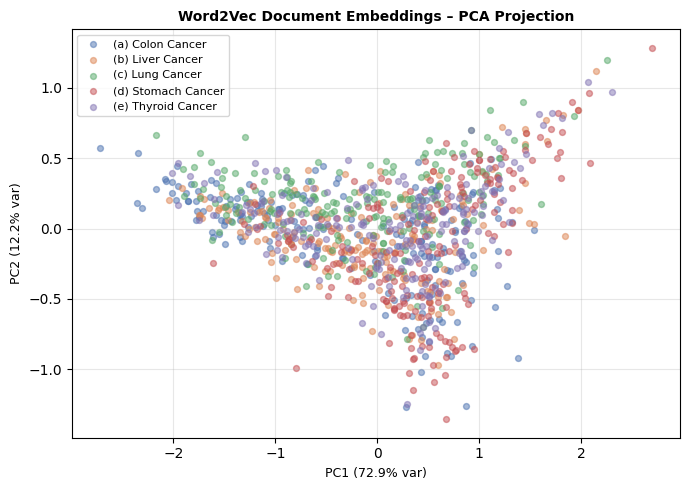

In [70]:
# Project 100-dim Word2Vec vectors to 2D with PCA to visualise category separation
pca      = PCA(n_components=2, random_state=42)
X_2d     = pca.fit_transform(X_w2v)
explained = pca.explained_variance_ratio_ * 100

fig, ax = plt.subplots(figsize=(7, 5))
for (lbl, cat), color in zip(FILE_LABEL.values(), COLORS):
    mask = processed['label'].values == lbl
    ax.scatter(X_2d[mask, 0], X_2d[mask, 1],
               label=f'({lbl}) {cat}', color=color, alpha=0.5, s=18)

ax.set_xlabel(f'PC1 ({explained[0]:.1f}% var)', fontsize=9)
ax.set_ylabel(f'PC2 ({explained[1]:.1f}% var)', fontsize=9)
ax.set_title('Word2Vec Document Embeddings – PCA Projection', fontsize=10, fontweight='bold')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('viz_w2v_pca.png', dpi=150)
plt.show()

---
## Step 7 – Save Feature Matrices

In [71]:
os.makedirs('features', exist_ok=True)

# Sparse matrices (BOW, TF-IDF) -> .npz
scipy.sparse.save_npz('features/X_bow.npz',   X_bow)
scipy.sparse.save_npz('features/X_tfidf.npz', X_tfidf)

# Dense arrays (LDA, Word2Vec) -> .npy
np.save('features/X_lda.npy', X_lda)
np.save('features/X_w2v.npy', X_w2v)

# Label array aligned with all feature matrices
np.save('features/labels.npy', processed['label'].values)

# Fitted vectorisers and LDA model (needed for vocabulary look-up / inverse transform)
with open('features/bow_vectorizer.pkl',   'wb') as f: pickle.dump(bow_vectorizer,   f)
with open('features/tfidf_vectorizer.pkl', 'wb') as f: pickle.dump(tfidf_vectorizer, f)
with open('features/lda_model.pkl',        'wb') as f: pickle.dump(lda_model,        f)

# Word2Vec model (needed for inference on new documents)
w2v_model.save('features/word2vec.model')

print('Saved to features/:')
for f in sorted(os.listdir('features')):
    size = os.path.getsize(os.path.join('features', f))
    print(f'  {f:<42} {size/1024:>7.1f} KB')

Saved to features/:
  X_bow.npz                                    113.4 KB
  X_lda.npy                                     39.2 KB
  X_tfidf.npz                                  458.4 KB
  X_w2v.npy                                    390.8 KB
  bow_vectorizer.pkl                           118.1 KB
  labels.npy                                     2.2 KB
  lda_model.pkl                                324.5 KB
  tfidf_vectorizer.pkl                         150.2 KB
  word2vec.model                              4165.4 KB
